### Kaggle Titanic Data 와 오차역전파를 이용한 예제 2

In [1]:
import numpy as np
import pandas as pd

# sigmoid 함수 정의
def sigmoid(x):
    return 1 / (1+np.exp(-x))

### pd.read_csv(),values 실행하면 제목과 함께 matrix 리턴됨

In [2]:
# Load Kaggle Data as matrix
train_csv_data = pd.read_csv('./(191116)titanic_train.csv').values
test_csv_data = pd.read_csv('./(191116)titanic_test.csv').values
test_csv_sub = pd.read_csv('./(191116)titanic_gender_submission.csv').values

print('train_csv_data.shape = ', train_csv_data.shape, ', type(train_csv_data) = ', type(train_csv_data))
print('test_csv_data.shape = ', test_csv_data.shape, ', type(test_csv_data) = ', type(test_csv_data))
print('test_csv_sub.shape = ', test_csv_sub.shape, ', type(test_csv_sub) = ', type(test_csv_sub))

#print('\n', train_csv_data[0], '\n')

# 각 column 내용 확인
#for column_index in range(len(train_csv_data[0])):
    
    #print('value = ', train_csv_data[0, column_index], ', type(column) = ', type(train_csv_data[0, column_index]))

train_csv_data.shape =  (891, 12) , type(train_csv_data) =  <class 'numpy.ndarray'>
test_csv_data.shape =  (418, 11) , type(test_csv_data) =  <class 'numpy.ndarray'>
test_csv_sub.shape =  (418, 2) , type(test_csv_sub) =  <class 'numpy.ndarray'>


### Data Conversion (문자 => 숫자)

In [3]:
# train data 에서 male -> 1.0, female -> 0.0
for i in range(len(train_csv_data)):
    
    if train_csv_data[i, 4] == 'male':
        
        train_csv_data[i, 4] = 1.0
    
    else:
        
        train_csv_data[i, 4] = 0.0
        
# test data 에서 male -> 1.0, female -> 0.0
for i in range(len(test_csv_data)):
    
    if test_csv_data[i, 3] == 'male':
        
        test_csv_data[i, 3] = 1.0
    
    else:
        
        test_csv_data[i, 3] = 0.0

In [4]:
# train data 에서 Embarked, Empty -> 0.0, S -> 1.0, C -> 2.0, Q -> 3.0
for i in range(len(train_csv_data)):
    
    if train_csv_data[i, 11] == 'S':
        
        train_csv_data[i, 11] = 1.0
        
    elif train_csv_data[i, 11] == 'C':
        
        train_csv_data[i, 11] = 2.0
        
    elif train_csv_data[i, 11] == 'Q':
        
        train_csv_data[i, 11] = 3.0
        
        
    if np.isnan(train_csv_data[i, 11]):
        
        train_csv_data[i, 11] = 0.0
        

# test data 에서 Embarked, Empty -> 0.0, S -> 1.0, C -> 2.0, Q -> 3.0
for i in range(len(test_csv_data)):
    
    if test_csv_data[i, 10] == 'S':
        
        test_csv_data[i, 10] = 1.0
        
    elif test_csv_data[i, 10] == 'C':
        
        test_csv_data[i, 10] = 2.0
        
    elif test_csv_data[i, 10] == 'Q':
        
        test_csv_data[i, 10] = 3.0
        
    if np.isnan(test_csv_data[i, 10]):
        
        test_csv_data[i, 10] = 0.0

### training data / test data 생성

In [5]:
training_x_data = train_csv_data[ : , [ 2, 4, 6, 7, 11 ] ]  # Pclass, Sex, SibSp, Parch, Embarked

training_t_data = train_csv_data[ :, 1:2]

test_x_data = test_csv_data[ : , [ 1, 3, 5, 6, 10 ] ]  # Pclass, Sex, SibSp, Parch, Embarked

test_t_data = test_csv_sub[ :, 1:2]  # test_csv_sub 에서 데이터 가져옴. 주의 요함


print("training_x_data.shape = ", training_x_data.shape, ", test_x_data.shape = ", test_x_data.shape)
print("training_t_data.shape = ", training_t_data.shape, ", test_t_data.shape = ", test_t_data.shape)

training_x_data.shape =  (891, 5) , test_x_data.shape =  (418, 5)
training_t_data.shape =  (891, 1) , test_t_data.shape =  (418, 1)


In [6]:
print('training_x_data[0] = ', training_x_data[0], ', type(training_x_data[0]) = ', type(training_x_data[0]))

for column_index in range(len(training_x_data[0])):
    
    print('data = ', training_x_data[0, column_index], ', type(data) = ', type(training_x_data[0, column_index]))

training_x_data[0] =  [3 1.0 1 0 1.0] , type(training_x_data[0]) =  <class 'numpy.ndarray'>
data =  3 , type(data) =  <class 'int'>
data =  1.0 , type(data) =  <class 'float'>
data =  1 , type(data) =  <class 'int'>
data =  0 , type(data) =  <class 'int'>
data =  1.0 , type(data) =  <class 'float'>


### 오차역전파로 구현되는 Kaggle_Titanic class 구현

In [7]:
from datetime import datetime      # datetime.now() 를 이용하여 학습 경과 시간 측정

class Kaggle_Titanic:
    
    def __init__(self, name, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        # 은닉층 가중치  W2 = Xavier/He 방법으로 self.W2 가중치 초기화
        self.W2 = np.random.randn(self.input_nodes, self.hidden_nodes) / np.sqrt(self.input_nodes/2)
        self.b2 = np.random.rand(self.hidden_nodes)      
        
        # 출력층 가중치는 W3 =  Xavier/He 방법으로 self.W3 가중치 초기화
        self.W3 = np.random.randn(self.hidden_nodes, self.output_nodes) / np.sqrt(self.hidden_nodes/2)
        self.b3 = np.random.rand(self.output_nodes)      
                        
        # 출력층 선형회귀 값 Z3, 출력값 A3 정의 (모두 행렬로 표시)
        self.Z3 = np.zeros([1,output_nodes])
        self.A3 = np.zeros([1,output_nodes])
        
        # 은닉층 선형회귀 값 Z2, 출력값 A2 정의 (모두 행렬로 표시)
        self.Z2 = np.zeros([1,hidden_nodes])
        self.A2 = np.zeros([1,hidden_nodes])
        
        # 입력층 선형회귀 값 Z1, 출력값 A1 정의 (모두 행렬로 표시)
        self.Z1 = np.zeros([1,input_nodes])    
        self.A1 = np.zeros([1,input_nodes])       
        
        # 학습률 learning rate 초기화
        self.learning_rate = learning_rate
        
        # name 초기화
        self.name = name
        
        print(self.name, " object is created !!!")
        
    def feed_forward(self):  
        
        delta = 1e-7    # log 무한대 발산 방지
        
        # 입력층 선형회귀 값 Z1, 출력값 A1 계산
        self.Z1 = self.input_data
        self.A1 = self.input_data
        
        # 은닉층 선형회귀 값 Z2, 출력값 A2 계산    
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = sigmoid(self.Z2)
        
        # 출력층 선형회귀 값 Z3, 출력값 A3 계산
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        y = self.A3 = sigmoid(self.Z3)
        
        return  -np.sum( self.target_data*np.log(y + delta) + (1-self.target_data)*np.log((1 - y)+delta ) )    
    
    def loss_val(self):
        
        delta = 1e-7    # log 무한대 발산 방지
        
        # 입력층 선형회귀 값 Z1, 출력값 A1 계산
        self.Z1 = self.input_data
        self.A1 = self.input_data
        
        # 은닉층 선형회귀 값 Z2, 출력값 A2 계산    
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = sigmoid(self.Z2)
        
        # 출력층 선형회귀 값 Z3, 출력값 A3 계산
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        y = self.A3 = sigmoid(self.Z3)
        
        return  -np.sum( self.target_data*np.log(y + delta) + (1-self.target_data)*np.log((1 - y)+delta ) )    
    
    # accuracy method
    def accuracy(self, input_data, target_data):
        
        matched_list = []
        not_matched_list = []
        
        # list which contains (index, label, prediction) value
        index_label_prediction_list = []
        
        temp_list = []
        
        for index in range(len(input_data)):
            
            # predict 를 위해서 vector 을 matrix 로 변환하여 인수로 넘겨줌
            # dtype=np.float32 해주지 않으면 sigmoid 에서 Numpy AttributeError: 'float' object has no attribute 'exp' 발생함
            # 해결방법 소스
            # https://stackoverflow.com/questions/18557337/numpy-attributeerror-float-object-has-no-attribute-exp/18568056
            (real_val, predicted_num) = self.predict(np.array(input_data[index], dtype=np.float32, ndmin=2)) 
            
            if predicted_num == target_data[index]:
                matched_list.append(index)
                
            else:
                not_matched_list.append(index)
                
                temp_list.append(index)
                temp_list.append(target_data[index])
                temp_list.append(predicted_num)
                
                index_label_prediction_list.append(temp_list)
                
                temp_list = []
                
        accuracy_result = len(matched_list) / len(input_data)
            
        print("Accuracy => ", accuracy_result)
            
        return matched_list, not_matched_list, index_label_prediction_list
    
    # train method
    def train(self, input_data, target_data):   
        
        self.target_data = target_data    
        self.input_data = input_data
        
        # 먼저 feed forward 를 통해서 최종 출력값과 이를 바탕으로 현재의 에러 값 계산
        loss_val = self.feed_forward()
        
        # 출력층 loss 인 loss_3 구함
        loss_3 = (self.A3-self.target_data) * self.A3 * (1-self.A3)
                        
        # 출력층 가중치 W3, 출력층 바이어스 b3 업데이트
        self.W3 = self.W3 - self.learning_rate * np.dot(self.A2.T, loss_3)   
        
        self.b3 = self.b3 - self.learning_rate * loss_3
        
        # 은닉층 loss 인 loss_2 구함        
        loss_2 = np.dot(loss_3, self.W3.T) * self.A2 * (1-self.A2)
        
        # 은닉층 가중치 W2, 은닉층 바이어스 b2 업데이트
        self.W2 = self.W2 - self.learning_rate * np.dot(self.A1.T, loss_2)   
        
        self.b2 = self.b2 - self.learning_rate * loss_2
        
        
    def predict(self, input_data):        # input_data 는 행렬로 입력됨     
        
        Z2 = np.dot(input_data, self.W2) + self.b2
        A2 = sigmoid(Z2)
        
        Z3 = np.dot(A2, self.W3) + self.b3
        y = A3 = sigmoid(Z3)
        
        if y >= 0.5:
            predicted_num = 1
        else:
            predicted_num = 0
    
        return y, predicted_num

#### 은닉층 1개를 가지는 객체 생성 및 학습

In [10]:
#hyper-parameter
i_nodes = training_x_data.shape[1]    # input nodes 개수
h1_nodes = 100  # hidden nodes 개수, 
o_nodes = 1    # output nodes 개수

lr = 1e-2      # learning rate

epochs = 200   # 반복횟수

# 손실함수 값을 저장할 list 생성
loss_val_list = []

# Kaggle_Titanic 객체 생성
titanic_obj = Kaggle_Titanic('Titanic', i_nodes, h1_nodes, o_nodes, lr)

print("Neural Network Learning using BackPropagation...")

start_time = datetime.now()

for step in range(epochs):
    
    for index in range(len(training_x_data)):
        
        input_data = training_x_data[index]
        target_data = training_t_data[index]
        
        # dtype=np.float32 해주지 않으면 sigmoid 에서 Numpy AttributeError: 'float' object has no attribute 'exp' 발생함
        # 해결방법 소스
        # https://stackoverflow.com/questions/18557337/numpy-attributeerror-float-object-has-no-attribute-exp/18568056
        titanic_obj.train( np.array(input_data, dtype=np.float32, ndmin=2), np.array([target_data], dtype=np.float32, ndmin=2) )  # 행렬로 입력
        
    if step % 10 == 0:
        print("epochs = ", step, "loss value = ", titanic_obj.loss_val())
        
    # 손실함수 값 저장
    loss_val_list.append(titanic_obj.loss_val()) 
    

end_time = datetime.now()
        
print("")
print("Elapsed Time => ", end_time - start_time)

Titanic  object is created !!!
Neural Network Learning using BackPropagation...
epochs =  0 loss value =  0.5184396860251979
epochs =  10 loss value =  0.38499496260769694
epochs =  20 loss value =  0.2858542444171589
epochs =  30 loss value =  0.2335678862860938
epochs =  40 loss value =  0.20409239993441738
epochs =  50 loss value =  0.18631503932687063
epochs =  60 loss value =  0.17512482010064004
epochs =  70 loss value =  0.16790342986541312
epochs =  80 loss value =  0.16318632592552576
epochs =  90 loss value =  0.16009541383609185
epochs =  100 loss value =  0.1580744130519293
epochs =  110 loss value =  0.1567561254000787
epochs =  120 loss value =  0.1558913927287531
epochs =  130 loss value =  0.15530850272893487
epochs =  140 loss value =  0.15488841524597058
epochs =  150 loss value =  0.1545486930751627
epochs =  160 loss value =  0.15423254521641105
epochs =  170 loss value =  0.1539010854201413
epochs =  180 loss value =  0.15352774325775498
epochs =  190 loss value = 

#### 정확도 계산

In [11]:
(true_list, false_list, index_label_prediction_list) = titanic_obj.accuracy(test_x_data, test_t_data) 

Accuracy =>  0.9617224880382775


#### 손실함수 트렌드 확인

200


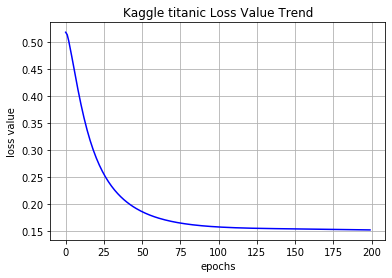

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

print(len(loss_val_list))

# 손실함수 추세 확인
Y_DATA_LIST = []

for index in range(0, len(loss_val_list)):
    Y_DATA_LIST.append(loss_val_list[index])
    
plt.title('Kaggle titanic Loss Value Trend')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.grid()
plt.plot(Y_DATA_LIST, color='b')
plt.show()